In [1]:
#to active our docker container
# sudo docker run -d --name opensearch-knn -p 9200:9200 -p 9600:9600 -e "discovery.type=single-node" -e "bootstrap.memory_lock=true" -e "OPENSEARCH_INITIAL_ADMIN_PASSWORD=a.Zerty12.3" --ulimit memlock=-1:-1 -v osdata:/usr/share/opensearch/data opensearchproject/opensearch:2.13.0

**Warning:** To easily work on our project, we use a local version of OpenSearch using Docker. The host, port, user and password must be change when needed, comments are written beside what must be change.

# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet.

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

In [2]:
# #comment to execute locally
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
#! ls drive/MyDrive/mpdw_project/

In [4]:
# #comment to execute locally
# my_path = 'drive/MyDrive/mpdw_project/'

#uncomment to execute locally
my_path = './'

In [5]:
! pip install yt-dlp

In [6]:
import json
from pprint import pprint
import subprocess

with open(my_path + 'activity_net.v1-3.min.json', 'r') as json_data:
    data = json.load(json_data)
    video_annotations = [
    {
        "video_id": vid,
        "num_moments": len(details["annotations"]),
        "url": details["url"],
        "duration": details["duration"]
    }
    for vid, details in data["database"].items()
    ]
    top_videos = sorted(video_annotations, key=lambda x: x["num_moments"], reverse=True)[:11]

    print(top_videos)


[{'video_id': 'o1WPnnvs00I', 'num_moments': 23, 'url': 'https://www.youtube.com/watch?v=o1WPnnvs00I', 'duration': 229.86}, {'video_id': 'oGwn4NUeoy8', 'num_moments': 23, 'url': 'https://www.youtube.com/watch?v=oGwn4NUeoy8', 'duration': 153.09}, {'video_id': 'VEDRmPt_-Ms', 'num_moments': 20, 'url': 'https://www.youtube.com/watch?v=VEDRmPt_-Ms', 'duration': 232.07999999999998}, {'video_id': 'qF3EbR8y8go', 'num_moments': 19, 'url': 'https://www.youtube.com/watch?v=qF3EbR8y8go', 'duration': 204.1}, {'video_id': 'DLJqhYP-C0k', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=DLJqhYP-C0k', 'duration': 186.968}, {'video_id': 't6f_O8a4sSg', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=t6f_O8a4sSg', 'duration': 218.52}, {'video_id': '6gyD-Mte2ZM', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=6gyD-Mte2ZM', 'duration': 188.245}, {'video_id': 'jBvGvVw3R-Q', 'num_moments': 18, 'url': 'https://www.youtube.com/watch?v=jBvGvVw3R-Q', 'duration': 218.62}, {'video_id

In [7]:
import os
import subprocess

# Directory where videos will be saved
download_path = my_path +"videos"
os.makedirs(download_path, exist_ok=True)  # Create folder if it doesn't exist

# Loop through each video in the top 10
for elt in top_videos:
    output_template = os.path.join(download_path, f"{elt['video_id']}.mp4")

    try:
        print(f"Downloading: {elt['url']}")
        # subprocess.run(["yt-dlp","-f", "best", "-o", output_template, elt['url']], check=True)
        print(f"Downloaded: {output_template}")
    except subprocess.CalledProcessError:
        print(f"Failed to download {elt['video_id']}.")

Downloading: https://www.youtube.com/watch?v=o1WPnnvs00I
Downloaded: ./videos\o1WPnnvs00I.mp4
Downloading: https://www.youtube.com/watch?v=oGwn4NUeoy8
Downloaded: ./videos\oGwn4NUeoy8.mp4
Downloading: https://www.youtube.com/watch?v=VEDRmPt_-Ms
Downloaded: ./videos\VEDRmPt_-Ms.mp4
Downloading: https://www.youtube.com/watch?v=qF3EbR8y8go
Downloaded: ./videos\qF3EbR8y8go.mp4
Downloading: https://www.youtube.com/watch?v=DLJqhYP-C0k
Downloaded: ./videos\DLJqhYP-C0k.mp4
Downloading: https://www.youtube.com/watch?v=t6f_O8a4sSg
Downloaded: ./videos\t6f_O8a4sSg.mp4
Downloading: https://www.youtube.com/watch?v=6gyD-Mte2ZM
Downloaded: ./videos\6gyD-Mte2ZM.mp4
Downloading: https://www.youtube.com/watch?v=jBvGvVw3R-Q
Downloaded: ./videos\jBvGvVw3R-Q.mp4
Downloading: https://www.youtube.com/watch?v=PJ72Yl0B1rY
Downloaded: ./videos\PJ72Yl0B1rY.mp4
Downloading: https://www.youtube.com/watch?v=QHn9KyE-zZo
Downloaded: ./videos\QHn9KyE-zZo.mp4
Downloading: https://www.youtube.com/watch?v=9-yueOtwiL8
Dow

In [8]:
import json

caption_files = [
    my_path + 'captions_dataset/train.json',
    my_path + 'captions_dataset/val_1.json',
    my_path + 'captions_dataset/val_2.json'
]

captions_per_video = {}

# Parse the caption files and retrieve sentences and timestamps for each video
for file in caption_files:
    with open(file, 'r') as f:
        data = json.load(f)
        for video_id, video_data in data.items():
            if video_id not in captions_per_video:
                captions_per_video[video_id] = {
                    "sentences": [],
                    "timestamps": []
                }
            captions_per_video[video_id]["sentences"].extend(video_data.get("sentences", []))
            captions_per_video[video_id]["timestamps"].extend(video_data.get("timestamps", []))

# Now associate sentences and timestamps with each video
for video in top_videos:
    video_id = "v_" + video["video_id"]
    data = captions_per_video.get(video_id, {})
    sentences = data.get("sentences", [])
    timestamps = data.get("timestamps", [])

    moments = []
    if len(sentences) == len(timestamps):
        # Create multiple moments for the video
        for sentence, timestamp in zip(sentences, timestamps):
            start = timestamp[0]
            end = timestamp[1]
            moment = {
                "start": start,
                "end": end,
                "description": sentence,
                "bow": list(set(sentence.lower().split()))  # Bag of words
            }
            moments.append(moment)  # Append the moment for each sentence
    else:
        print(f"Warning: Mismatch for {video_id} — {len(sentences)} sentences vs {len(timestamps)} timestamps")
    #print(moments)
    # Update the video with the list of moments
    video["moments"] = moments
    #print(f"Video {video_id} has {len(moments)} moments.")

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

In [9]:
# ! pip install av

In [10]:
import av
import av.datasets
import os

video_folder = my_path + "videos"
output_folder = my_path + "frames"

for video in os.listdir(video_folder):
    # File name without extension
    filename = os.path.splitext(video)[0]
    # if not os.path.isdir(output_folder + "/" + filename):
    #     os.makedirs(output_folder + "/" + filename)
    # with av.open(video_folder + "/" + video) as container:
    #     stream = container.streams.video[0]
    #     # We want 1 frame per second
    #     fps = stream.average_rate
    #     interval = int(fps)
    #     #print(fps)
    #     cpt = 0
    #     for i,frame in enumerate(container.decode(stream)):
    #         if i % interval == 0:
    #             frame.to_image().save(output_folder+"/"+filename+"/"+str(cpt)+".jpg", quality=80)
    #             cpt += 1

## Video metadata

Process the video metadata provided in the `json` file and index the video data in OpenSearch.

In [11]:
# ! pip install opensearch-py

In [12]:
# Connect to OpenSearch and then create the index if it doesn't exist yet

from opensearchpy import OpenSearch
import pprint as pp


host = 'localhost' #api.novasearch.org
port = 9200 #443

user = 'admin' # Add your user name here: user01 on OpenSearch
password = 'a.Zerty12.3' # Add your user password here: erasmus+2025
index_name = user

client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_auth = (user, password),
    use_ssl = True,
    verify_certs = False,
)

index_body = {
   "settings":{
      "index":{
         "number_of_replicas":0,
         "number_of_shards":4,
         "refresh_interval":"-1",
         "knn":"true"
      }
   },
  "mappings": {
    "properties": {
      "vid_id": {
        "type": "keyword"
      },
      "moment_description": {
        "type": "text",
        "analyzer": "standard"
      },
      "start_timestamp": {
        "type": "float"
      },
      "end_timestamp": {
        "type": "float"
      },
      "video_length": {
        "type": "float"
      },
      "caption_bow": {
        "type": "text",
        "analyzer": "standard"
      }
      # "caption_vec": { #implemented after
      #   "type": "knn_vector",
      #   "dimension": 384, #Depend on the embedding model
      #   "index": True,
      #   "similarity": "cosine"
      # },
      # "keyframe_vec": {
      #   "type": "knn_vector",
      #   "dimension": 768,
      #   "index": True,
      #   "similarity": "cosine"
      # },
    }
  }
}

if client.indices.exists(index=index_name):
    print("Index already existed. Nothing to be done.")
else:
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index:')
    print(response)

Index already existed. Nothing to be done.


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\opensearchpy\connection\http_urllib3.py:214: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [13]:
#Index every moments on OpenSearch (only do it once per index, if else it will make copies)
for video in top_videos:
        video_id = video['video_id']
        for moment in video['moments']:
            #print("Nb moments: ",len(video['moments']))
            document = {
                "vid_id": video_id,
                "start_timestamp": moment["start"],
                "end_timestamp": moment["end"],
                "video_length": video["duration"],
                "caption_bow": moment["bow"],
                #"caption_vec": moment["caption_vec"][0],  # This should be a list of floats (embedding)
                "moment_description": moment["description"]
            }
            # Index the document in OpenSearch
            response = client.index(index=index_name, body=document)
            #print(response)


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\sit

In [14]:
# Give every documents added to the index
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match_all": {}
    },
    "size": 100  # Adjust the number to see more results if needed
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
for hit in response['hits']['hits']:
    print(hit['_source'])  # Print the source of each document

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Total hits: 748
{'vid_id': 'VEDRmPt_-Ms', 'start_timestamp': 205.39, 'end_timestamp': 232.08, 'video_length': 232.07999999999998, 'caption_bow': ['participants', 'the', 'on', 'receiveng', 'podium', 'are', 'medals.', 'thei'], 'caption_vec': [-0.06475929170846939, 0.13591709733009338, 0.002720533637329936, -0.03553730994462967, -0.038473330438137054, 0.11150244623422623, 0.04677435755729675, -0.009831438772380352, 0.04769115149974823, -0.01688740961253643, -0.037409473210573196, -0.07916895300149918, -0.022811556234955788, 0.03679289296269417, -0.08735924959182739, -0.05594445392489433, 0.00883602723479271, 0.07668766379356384, 0.003891606582328677, -0.015154924243688583, 0.06374325603246689, -0.024104563519358635, -0.0430002436041832, 0.08225473016500473, -0.014270293526351452, 0.04819701611995697, -0.14002694189548492, 0.020672447979450226, 0.047669995576143265, 0.05264006555080414, -0.0706339180469513, -0.0531199648976326, -0.005852443166077137, 0.053403422236442566, -0.08969072252511

In [15]:
# Search based on words in the description
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match": {
            "moment_description":{
                "query": "man",
                "operator": "and"
            }
        }
    },
    "size":100
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
for hit in response['hits']['hits']:
    print(hit['_source'])  # Print the source of each document

Total hits: 220
{'vid_id': '9-yueOtwiL8', 'start_timestamp': 108.42, 'end_timestamp': 118.81, 'video_length': 230.69, 'caption_bow': ['trows', 'man', 'a', 'another', 'disc.'], 'caption_vec': [0.021958429366350174, -0.050997957587242126, -0.07126843929290771, -0.029573678970336914, -0.131214439868927, -0.10061390697956085, 0.14006048440933228, 0.04583430290222168, 0.0068339151330292225, 0.012098805047571659, 0.07044816762208939, 0.04506327211856842, 0.016263538971543312, 0.029546819627285004, -0.008344953879714012, -0.029653798788785934, -0.07047237455844879, -0.02008521556854248, 0.02635332942008972, 0.009070197120308876, 0.06458886712789536, 0.04844572767615318, -0.05918562412261963, -0.040767211467027664, -0.055184025317430496, -0.07811176776885986, -0.012522361241281033, 0.04866619408130646, 0.021036626771092415, -0.016638258472085, 0.04871988669037819, 0.06206473708152771, -0.038168758153915405, -0.03150021284818649, 5.49404239791329e-06, -0.056005675345659256, -0.0596148818731308,

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## Embeddings Neighborhood

In [16]:
# Compute the caption_vectors

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


# Load the model on GPU if available
device = torch.device("cpu")
model = model.to(device)

# Encode sentences
for video in top_videos:
    moments = video['moments']
    for moment in moments:
        caption = [moment["description"] for moment in moments]
        caption_vector = encode(caption)
        moment["caption_vec"] = caption_vector.tolist()

        #print(moment["caption_vec"])


In [17]:
# Process each document and add embeddings and save to a JSON file
query = {
    "query": {
        "match_all": {}
    }
}

# Retrieve all documents from the index
response = client.search(index=index_name, body=query, size=1000)
documents = response["hits"]["hits"]

# Update each document with the new caption_vec field
for document in documents:
    caption = document["_source"]["moment_description"]  # Get the caption from the document
    caption_vector = encode([caption])  # Generate embedding for the caption
    document["caption_vec"] = caption_vector.tolist()[0]  # Convert tensor to list


# Save the documents to a JSON file
output_file = "documents_with_embeddings.json"
with open(output_file, "w") as f:
    json.dump(documents, f, indent=4)

print(f"Documents with embeddings have been saved to {output_file}")

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Documents with embeddings have been saved to documents_with_embeddings.json


In [18]:
#check the number of elements in the file to see if it worked
import json

# Load the JSON file
file_path = "documents_with_embeddings.json"

with open(file_path, "r") as json_file:
    data = json.load(json_file)

# count the number of elements with the "id" field
count = sum(1 for item in data if "_id" in item)

print(f"Number of element : {count}")

Number of element : 748


In [19]:
#revision of the index mapping
# New mapping for caption_vec
new_field_mapping = {
    "properties": {
        "caption_vec": {
            "type": "knn_vector",
            "dimension": 384,  # depend on the embedding model
            "index": True,
            "similarity": "cosine"
        }
    }
}

# Update the index mapping
response = client.indices.put_mapping(
    index=index_name,  # index name
    body=new_field_mapping
)

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [20]:
#add the embeddings to the index
# Update the documents with caption_vec
query = {
    "query": {
        "match_all": {}
    }
}

# Retrieve all documents from the index
response = client.search(index=index_name, body=query, size=1000)
documents = response["hits"]["hits"]

# Update each document with the new caption_vec field
for doc in documents:
    doc_id = doc["_id"]  # ID document

    caption = doc["_source"]["moment_description"]  # Get the caption from the document
    caption_vector = encode([caption])  # Generate embedding for the caption
    embedding = caption_vector.tolist()[0]  # Convert tensor to list
    #print(embedding)

    # Update the document with the new field
    update_body = {
        "doc": {
            "caption_vec": embedding
        }
    }
    update_response = client.update(index=index_name, id=doc_id, body=update_body)


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\sit

In [21]:
# Refresh the index to make the changes visible
client.indices.refresh(index=index_name)
query = {
    "query": {
        "match_all": {}
    },
    "size": 100  # Adjust the number to see more results if needed
}

response = client.search(
    index=index_name,
    body=query
)

# Print the total number of documents and some of the documents
print(f"Total hits: {response['hits']['total']['value']}")
# for hit in response['hits']['hits']:
#     print(hit['_source'])  # Print the source of each document                "moment_description": moment["description"]

Total hits: 748


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [22]:
# test the search functionality
client.indices.refresh(index=index_name)
query1 = "a woman is playing guitar"
def test_embedding_neighbor_search(query):
    # Encode the query
    query_emb = encode([query])
    query = {
        "query": {
            "knn": {
                "caption_vec":{
                    "vector": query_emb[0].numpy(),
                    "k": 1
                }
            }
        },
        "size":1
    }

    response = client.search(
        index=index_name,
        body=query
    )

    print('\nThe closest result is:')
    pp.pprint(response['hits']['hits'][0]['_source']['moment_description'])  # Print the source of each document
    print('\nThe video ID is:')
    pp.pprint(response['hits']['hits'][0]['_source']['vid_id'])  # Print the source of each document
    print('\nThe score is:')
    pp.pprint(response['hits']['hits'][0]['_score'])  # Print the source of each document
    return query_emb, response['hits']['hits'][0]['_source']['moment_description'], response['hits']['hits'][0]['_source']['vid_id'], response['hits']['hits'][0]['_score'], response['hits']['hits'][0]['_source']['caption_vec']

test_embedding_neighbor_search(query1)

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(



The closest result is:
(' A woman begins playing the drums while another plays piano and the others '
 'watch.')

The video ID is:
'oGwn4NUeoy8'

The score is:
0.467414


(tensor([[ 1.5873e-03, -4.7035e-02,  8.5407e-03, -5.0150e-02, -1.3642e-01,
           4.0522e-02, -3.4070e-03,  2.6322e-02, -1.6691e-03,  7.1940e-02,
           4.9844e-03, -3.8714e-02, -5.2650e-02, -5.3223e-02, -2.8777e-02,
           6.0005e-02,  2.1875e-02,  5.2675e-02,  6.8632e-02,  4.5677e-02,
           1.8511e-02,  5.2403e-02, -4.8800e-02,  1.3975e-03, -2.4587e-02,
           2.4502e-02, -9.9911e-04,  1.0150e-01, -5.2853e-02, -2.7174e-02,
           8.4959e-03,  6.1221e-02, -3.1494e-02, -2.2682e-02, -5.7154e-02,
           5.7389e-02, -9.1568e-02, -3.5503e-02,  2.2813e-02, -1.2874e-02,
          -1.8797e-02, -2.7378e-02,  1.3035e-02, -7.3034e-02, -4.1507e-02,
          -7.0417e-02,  1.1858e-02,  3.8586e-02, -8.2920e-02, -1.1029e-01,
           4.0799e-02,  5.7635e-02, -3.7775e-02, -4.3106e-02,  6.3751e-02,
           1.4372e-02, -5.2516e-02,  2.4377e-02,  4.2141e-03,  4.5926e-03,
           9.9565e-03,  4.3632e-02,  9.9430e-03,  1.9786e-02,  8.3163e-03,
          -5.8558e-02,  7

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

def plot_query_caption_pairs(
    query_vectors,
    caption_vectors,
    similarity_scores=None,
    query_texts=None,
    caption_texts=None,
    use_tsne=False,
    max_text_length=30,
    figsize=(12, 8)
):
    """
    Visualization of query-caption pairs with optional PCA/T-SNE.
    """
    # Convert and normalize
    query_vectors = normalize(np.array(query_vectors).reshape(len(query_vectors), -1))
    caption_vectors = normalize(np.array(caption_vectors).reshape(len(caption_vectors), -1))
    
    assert query_vectors.shape == caption_vectors.shape, "Shapes must match"
    if similarity_scores:
        assert all(-1 <= s <= 1 for s in similarity_scores), "Similarity scores must be in [-1, 1]"

    # Combine vectors and reduce dimensions
    all_vectors = np.vstack([query_vectors, caption_vectors])
    
    #choose reduction method and reduce dimensions
    if use_tsne and len(all_vectors) > 3:
        reducer = TSNE(n_components=2, perplexity=min(30, len(all_vectors) - 1), random_state=42)
    else:
        reducer = PCA(n_components=2)
    reduced = reducer.fit_transform(all_vectors)
    reduced_queries, reduced_captions = reduced[:len(query_vectors)], reduced[len(query_vectors):]

    # Plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        reduced_queries[:, 0], reduced_queries[:, 1], 
        color='red', label='Queries', s=100, alpha=0.7
    )
    plt.scatter(
        reduced_captions[:, 0], reduced_captions[:, 1], 
        color='green', label='Best Captions', s=100, alpha=0.7
    )

    # Add lines and annotations
    for i in range(len(query_vectors)):
        plt.plot(
            [reduced_queries[i, 0], reduced_captions[i, 0]],
            [reduced_queries[i, 1], reduced_captions[i, 1]],
            'k--', alpha=0.3
        )
        if similarity_scores:
            plt.text(
                (reduced_queries[i, 0] + reduced_captions[i, 0]) / 2,
                (reduced_queries[i, 1] + reduced_captions[i, 1]) / 2,
                f"{similarity_scores[i]:.2f}", fontsize=9, ha='center'
            )
        if query_texts:
            plt.text(
                reduced_queries[i, 0] + 0.3, reduced_queries[i, 1] + 0.3,
                query_texts[i][:max_text_length] + ("..." if len(query_texts[i]) > max_text_length else ""),
                fontsize=8, color='darkred'
            )
        if caption_texts:
            plt.text(
                reduced_captions[i, 0] + 0.3, reduced_captions[i, 1] + 0.3,
                caption_texts[i][:max_text_length] + ("..." if len(caption_texts[i]) > max_text_length else ""),
                fontsize=8, color='darkgreen'
            )

    plt.title("Queries vs Most Similar Captions (PCA)" if not use_tsne else "Queries vs Captions (t-SNE)")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()




 A few other men are shown playing guitars as they sit.

The closest result is:
' A few other men are shown playing guitars as they sit.'

The video ID is:
'o1WPnnvs00I'

The score is:
1.0



A dog running in the park

The closest result is:
' man is doing a javeling throw in a big large field.'

The video ID is:
'9-yueOtwiL8'

The score is:
0.3874925



A group of people in a meeting

The closest result is:
' The group plays for the audience, occasionally zooming in on individuals.'

The video ID is:
'o1WPnnvs00I'

The score is:
0.48390615



A sunset over the ocean


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\hugow\miniconda3\envs\mpdw\lib\sit


The closest result is:
(' woman used some black painting for make details, put the red stamp on the '
 'corner and finished the painting with yellow and reddetails on the flowers.')

The video ID is:
'qF3EbR8y8go'

The score is:
0.39068225


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\hugow\miniconda3\envs\mpdw\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\hugow\miniconda3\envs\mpdw\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\hugow\miniconda3\envs\mpdw\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, arg

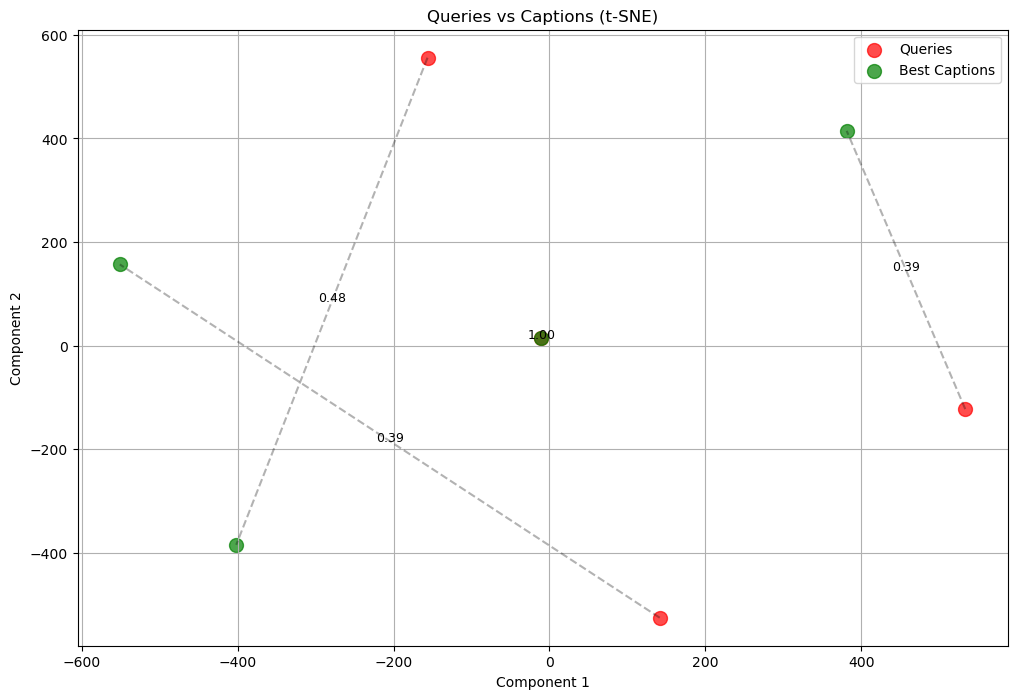

In [24]:
#we can test it with different queries
queries = [
    " A few other men are shown playing guitars as they sit.",
    "A dog running in the park",
    "A group of people in a meeting",
    "A sunset over the ocean"
]

query_vectors=[]
caption_result=[]
scores=[]
for elt in queries:
    print("\n\n")
    print(elt)
    query_vec, captions, video_id, score, caption_vector = test_embedding_neighbor_search(elt)
    #print(len(np.array(query_vec)[0]))
    #print(len(caption_vector))
    query_vectors.append(query_vec)
    caption_result.append(caption_vector)
    scores.append(score)
plot_query_caption_pairs(query_vectors, caption_result, scores, query_texts=None, caption_texts=None, use_tsne=True)

## Constrained Embedding Searches

In [25]:
# ! pip install bertviz

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoConfig, AutoTokenizer
from bertviz import head_view, model_view
from sentence_transformers import SentenceTransformer
from opensearchpy import OpenSearch

In [27]:
host = 'localhost' #api.novasearch.org
port = 9200 #443
user = 'admin' #user01 
password = 'a.Zerty12.3' #erasmus+2025
index_name = 'admin'

client = OpenSearch(
    hosts=[{'host': host, 'port': port}],
    http_auth=(user, password),
    use_ssl=True,
    verify_certs=False,
)

# Instanciate a SentenceTransformer model (for embeddings research)
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\opensearchpy\connection\http_urllib3.py:214: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(


In [28]:
def text_search(query_text):
    """
    Simple request on 'moment_description' field.
    """
    body = {
        "query": {
            "match": {
                "moment_description": query_text
            }
        },
        "size": 10
    }
    response = client.search(index=index_name, body=body)
    return response

In [29]:
def knn_search(query_text, k=5):
    """
    k-NN search on 'caption_vec' field.
    """
    query_embedding = model.encode([query_text])[0].tolist()
    body = {
        "size": k,
        "query": {
            "knn": {
                "caption_vec": {
                    "vector": query_embedding,
                    "k": k
                }
            }
        }
    }
    response = client.search(index=index_name, body=body)
    return response

In [30]:
def text_with_boolean_filter(query_text, min_duration=0, max_duration=100000):
    """
    Text search + Boolean filter on video duration.
    """
    body = {
        "query": {
            "bool": {
                "must": [
                    {
                        "match": {
                            "moment_description": query_text
                        }
                    }
                ],
                "filter": [
                    {
                        "range": {
                            "video_length": {
                                "gte": min_duration,
                                "lte": max_duration
                            }
                        }
                    }
                ]
            }
        },
        "size": 10
    }
    response = client.search(index=index_name, body=body)
    return response

In [31]:
def knn_with_boolean_filter(query_text, min_duration=0, max_duration=100000, k=5):
    """
    Search k-NN embeddings + boolean filter on video duration.
    """
    query_embedding = model.encode([query_text])[0].tolist()
    body = {
        "size": k,
        "query": {
            "bool": {
                "must": [
                    {
                        "knn": {
                            "caption_vec": {
                                "vector": query_embedding,
                                "k": k
                            }
                        }
                    }
                ],
                "filter": [
                    {
                        "range": {
                            "video_length": {
                                "gte": min_duration,
                                "lte": max_duration
                            }
                        }
                    }
                ]
            }
        }
    }
    response = client.search(index=index_name, body=body)
    return response

In [32]:
print("=== Simple text search ===")
resp_text = text_search("dog playing in water")
print(resp_text)

=== Simple text search ===
{'took': 3, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 198, 'relation': 'eq'}, 'max_score': 5.091407, 'hits': [{'_index': 'admin', '_id': 'S4TKJZYBuTFPoLPkWbFD', '_score': 5.091407, '_source': {'vid_id': 'o1WPnnvs00I', 'start_timestamp': 0, 'end_timestamp': 16.09, 'video_length': 229.86, 'caption_bow': ['flute', 'microphone.', 'of', 'is', 'man', 'in', 'front', 'a', 'playing'], 'caption_vec': [0.033841822296381, -0.0068005286157131195, -0.000981673481874168, -0.08312954008579254, -0.13254885375499725, 0.03544168919324875, 0.07480097562074661, -0.03751228004693985, 0.014732320792973042, -0.028699340298771858, -0.03486845642328262, -0.0671839788556099, -0.12319914996623993, -0.01646171510219574, 0.07228060811758041, -0.06964744627475739, -0.014246703125536442, 0.004854960832744837, 0.05674833804368973, -0.03019833192229271, 0.020521925762295723, 0.11677190661430359, -0.04872553050518036, -

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [33]:
print("\n=== Vectorial search (k-NN) ===")
resp_knn = knn_search("someone is playing guitar", k=3)
print(resp_knn)


=== Vectorial search (k-NN) ===


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


{'took': 2, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 48, 'relation': 'eq'}, 'max_score': 0.5024685, 'hits': [{'_index': 'admin', '_id': '0mjjOZYBfE9mJMVpNpv9', '_score': 0.5024685, '_source': {'vid_id': 'o1WPnnvs00I', 'start_timestamp': 18.39, 'end_timestamp': 83.9, 'video_length': 229.86, 'caption_bow': ['men', 'shown', 'a', 'sit.', 'as', 'they', 'playing', 'guitars', 'are', 'few', 'other'], 'caption_vec': [0.03824940323829651, -0.026105452328920364, -0.01730249635875225, -0.04970202222466469, -0.09701532125473022, 0.032272208482027054, -0.013945253565907478, -0.05481712892651558, -0.021722974255681038, 0.03181031346321106, -0.015917429700493813, 0.017956728115677834, 0.038774751126766205, -0.057699594646692276, -0.007281114347279072, -0.06098489463329315, -0.003347155172377825, 0.008831256069242954, 0.02208906225860119, 0.004209954757243395, -0.0023997805546969175, 0.07561731338500977, -0.04835757613182068, -

In [34]:
print("\n=== Filters + text ===")
resp_filt = text_with_boolean_filter("football match", min_duration=60, max_duration=300)
print(resp_filt)


=== Filters + text ===
{'took': 1, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}}


C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [35]:
print("\n=== Filters + vectorial ===")
resp_knn_filt = knn_with_boolean_filter("swimming pool", min_duration=100, max_duration=600, k=5)
print(resp_knn_filt)

C:\Users\hugow\miniconda3\envs\mpdw\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(



=== Filters + vectorial ===
{'took': 2, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 80, 'relation': 'eq'}, 'max_score': 0.40336215, 'hits': [{'_index': 'admin', '_id': 'eYTKJZYBuTFPoLPkY7H3', '_score': 0.40336215, '_source': {'vid_id': 'PJ72Yl0B1rY', 'start_timestamp': 1.03, 'end_timestamp': 206.37, 'video_length': 206.332, 'caption_bow': ['different', 'group', 'cheerleaders.', 'several', 'surrounded', 'by', 'soccer', 'games', 'of', 'audiences', 'athletes', 'play', 'locations', 'and', 'in', 'dancing', 'a', 'bleachers', 'beach'], 'caption_vec': [0.0767095759510994, -0.01151563785970211, -0.0054469904862344265, -0.09294364601373672, 0.07745246589183807, 0.02826443314552307, 0.021432936191558838, -0.049165260046720505, 0.05567710101604462, 0.06998384743928909, -0.02516942285001278, -0.032966576516628265, 0.009760472923517227, 0.025615455582737923, 0.11223649978637695, -0.04378828406333923, -0.055725183337926865, -0.

## Contextual Embeddings and Self-Attention

In [36]:
def visualize_contextual_embeddings(model_name, sentences, layers_to_inspect=range(12)):
    """
    Visualizes contextual word embeddings for multiple sentences from layer 0 to layer 11 (or a custom range).
    It uses PCA to project the embeddings to 2D. You can observe how the embeddings
    evolve from lower layers (layer 0) to higher layers (layer 11).
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    # Tokenize the sentences with truncation and padding
    inputs = tokenizer(sentences, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Retrieve hidden states
    hidden_states = outputs.hidden_states  # Tuple of shape (layers, batch_size, seq_len, hidden_dim)
    tokens_batch = [tokenizer.convert_ids_to_tokens(seq) for seq in inputs['input_ids']]

    # Flatten tokens from both sentences
    tokens = [token for sentence_tokens in tokens_batch for token in sentence_tokens]

    # Create subplots grid for visualization
    rows, cols = 3, 4  # Adjust based on the number of layers
    fig, ax_full = plt.subplots(rows, cols)
    fig.set_figheight(rows * 4)
    fig.set_figwidth(cols * 4 + 3)
    plt.rcParams.update({'font.size': 6})

    layer_index = 0
    for r in range(rows):
        for c in range(cols):
            if layer_index >= len(layers_to_inspect):
                break  # Stop if all layers have been visualized

            ax = ax_full[r, c]
            current_layer = layers_to_inspect[layer_index]

            # Get embeddings for the current layer
            embeddings = torch.cat([hidden_states[current_layer][i] for i in range(inputs['input_ids'].shape[0])], dim=0).detach().numpy()

            # Reduce dimensions using PCA
            if embeddings.shape[1] == 2:
                twodim = embeddings
            else:
                twodim = PCA(n_components=2).fit_transform(embeddings)

            # Plot embeddings for the current layer
            ax.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
            for word, (x, y) in zip(tokens, twodim):
                ax.text(x + 0.05, y + 0.05, word, fontsize=8)

            # Set layer title
            ax.set_title(f"Layer {current_layer}")
            layer_index += 1

    fig.suptitle("Visualization of all output embeddings from all layers")
    plt.tight_layout()
    plt.show()

In [37]:
def visualize_positional_embeddings_scatter(model_name, word="hello", num_tokens=20, layer_id=0):
    """
    Visualizes the embeddings of a repeated token spatially in 2D using PCA.
    Only the word is shown, without [CLS], [SEP].
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    model = AutoModel.from_pretrained(model_name, config=config)
    model.eval()

    sentence = " ".join([word] * num_tokens)
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states
    layer_emb = hidden_states[layer_id][0].cpu().numpy()  # (seq_len, hidden_dim)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    indices = [i for i, tok in enumerate(tokens) if tok == word]
    filtered_emb = layer_emb[indices]

    pca = PCA(n_components=2)
    points_2d = pca.fit_transform(filtered_emb)

    plt.figure(figsize=(10, 8))
    for idx, (x, y) in enumerate(points_2d):
        plt.scatter(x, y, color='royalblue', s=60)
        plt.text(x, y, f"{word}_{idx+1}", fontsize=9, color='royalblue', ha='center')
    plt.title(f"2D PCA of '{word}' repeated {num_tokens} times (layer {layer_id})", fontsize=15)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [38]:
def visualize_positional_embeddings_matrix(model_name, repeated_word="hello", num_tokens=20, layer_id=0):
    """
    Feeds a sequence of the same token repeated num_tokens times, then visualizes
    the embeddings or distances across these tokens in a given layer.

    The idea is to see how positional encoding differentiates tokens that are
    otherwise identical in text but occur in different positions.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    sentence = " ".join([repeated_word] * num_tokens)
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states
    all_tokens_emb = hidden_states[layer_id][0].detach().numpy()

    dist_matrix = np.zeros((num_tokens, num_tokens))
    for i in range(num_tokens):
        for j in range(num_tokens):
            dist_matrix[i, j] = np.linalg.norm(all_tokens_emb[i] - all_tokens_emb[j])

    plt.figure(figsize=(8, 6))
    plt.title(f"Distance Matrix for Layer {layer_id} - '{repeated_word}' repeated {num_tokens} times")
    plt.imshow(dist_matrix, cmap='viridis')
    plt.colorbar(label="Euclidean Distance")
    plt.xlabel("Token Index")
    plt.ylabel("Token Index")
    plt.show()

In [39]:
def compare_self_attention(model_name_cross, model_name_dual, text_a, text_b):
    """
    Compares the self-attention patterns for a cross-encoder (text_a and text_b
    in the same input with a [SEP] token) vs. a dual-encoder (each text processed
    separately). Visualizes them via bertviz head_view.
    """
    # -- Cross-Encoder --
    tokenizer_cross = AutoTokenizer.from_pretrained(model_name_cross)
    config_cross = AutoConfig.from_pretrained(model_name_cross, output_hidden_states=True, output_attentions=True)
    model_cross = AutoModel.from_pretrained(model_name_cross, config=config_cross)

    inputs_cross = tokenizer_cross.encode_plus(
        text_a,
        text_b,
        return_tensors='pt',
        add_special_tokens=True,
        max_length=512,
        truncation=True
    )
    with torch.no_grad():
        outputs_cross = model_cross(**inputs_cross)

    attentions_cross = outputs_cross.attentions
    tokens_cross = tokenizer_cross.convert_ids_to_tokens(inputs_cross["input_ids"][0])

    print("\n=== CROSS-ENCODER ATTENTION (head_view) ===")
    head_view(attentions_cross, tokens_cross)

    # -- Dual-Encoder --
    tokenizer_dual = AutoTokenizer.from_pretrained(model_name_dual)
    config_dual = AutoConfig.from_pretrained(model_name_dual, output_hidden_states=True, output_attentions=True)
    model_dual = AutoModel.from_pretrained(model_name_dual, config=config_dual)

    inputs_dual_a = tokenizer_dual.encode_plus(text_a, return_tensors='pt', add_special_tokens=True)
    inputs_dual_b = tokenizer_dual.encode_plus(text_b, return_tensors='pt', add_special_tokens=True)

    with torch.no_grad():
        outputs_dual_a = model_dual(**inputs_dual_a)
        outputs_dual_b = model_dual(**inputs_dual_b)

    tokens_dual_a = tokenizer_dual.convert_ids_to_tokens(inputs_dual_a["input_ids"][0])
    tokens_dual_b = tokenizer_dual.convert_ids_to_tokens(inputs_dual_b["input_ids"][0])

    print("\n=== DUAL-ENCODER ATTENTION (text_a) ===")
    head_view(outputs_dual_a.attentions, tokens_dual_a)

    print("\n=== DUAL-ENCODER ATTENTION (text_b) ===")
    head_view(outputs_dual_b.attentions, tokens_dual_b)

In [40]:
def interpretability_attention(model_name, text_a, text_b):
    """
    Visualizes how tokens attend to each other across layers, exploring how
    attention might relate to the model's final outputs. The function uses
    model_view from bertviz for an all-layer perspective.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    inputs = tokenizer.encode_plus(text_a, text_b, return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    print("\n=== MODEL VIEW ATTENTION ===")
    model_view(attentions, tokens)

In [41]:
def visualize_full_self_attention(model_name, text_a, text_b):
    """
    Creates a grid of subplots (layers x heads) to plot the entire self-attention
    matrix per head in each layer. This helps you inspect every attention map
    statically in one figure. Optionally uses bertviz for interactive analysis.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name, output_attentions=True)
    model = AutoModel.from_pretrained(model_name, config=config)

    inputs = tokenizer.encode_plus(
        text_a,
        text_b,
        return_tensors='pt',
        add_special_tokens=True,
        max_length=512,
        truncation=True
    )
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]

    fig, axes = plt.subplots(nrows=num_layers, ncols=num_heads, figsize=(3 * num_heads, 3 * num_layers))
    fig.suptitle("Self-Attention Matrices for All Layers & Heads", fontsize=16)

    for layer_i in range(num_layers):
        for head_j in range(num_heads):
            ax = axes[layer_i, head_j] if num_layers > 1 else axes[head_j]
            attention_matrix = attentions[layer_i][0, head_j].detach().numpy()
            im = ax.imshow(attention_matrix, cmap='viridis')
            ax.set_title(f"Layer {layer_i}, Head {head_j}")
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    # head_view(attentions, tokens)

### Contextual embeddings

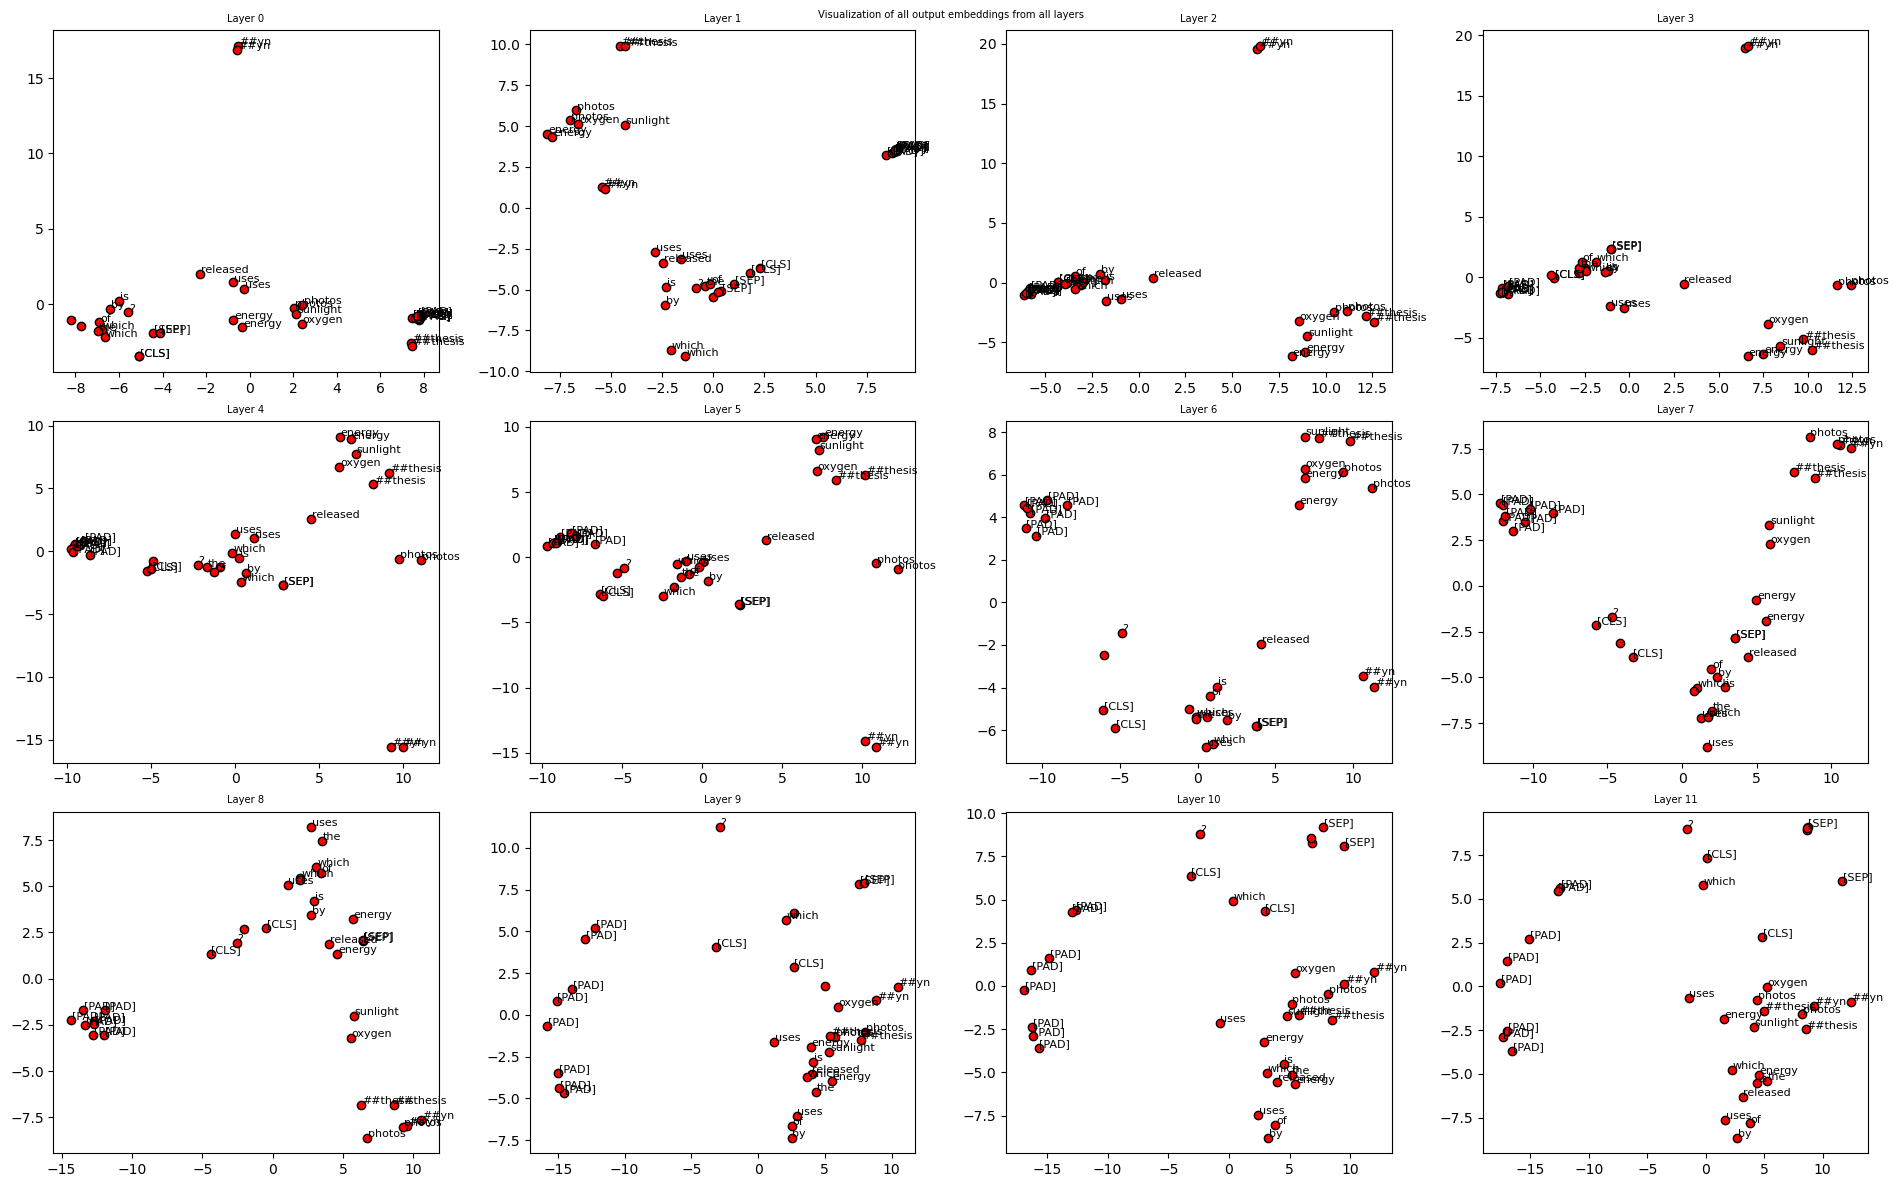

In [42]:
text_a = "Photosynthesis uses which energy?"
text_b = "Oxygen is released by photosynthesis, which uses the energy of sunlight."
visualize_contextual_embeddings(
    model_name="bert-base-uncased",
    sentences=[text_a,text_b],
    layers_to_inspect=range(12)  # 0..11
)

### Positional embeddings

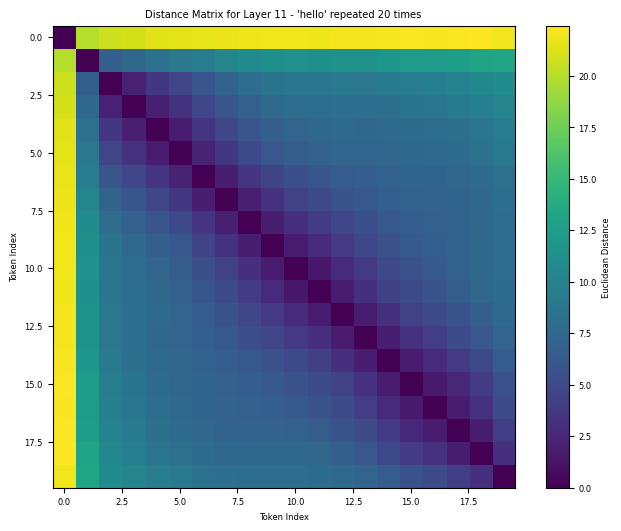

In [43]:
visualize_positional_embeddings_matrix(
    model_name="bert-base-uncased",
    repeated_word="hello",
    num_tokens=20,
    layer_id=11  # try different layers
)

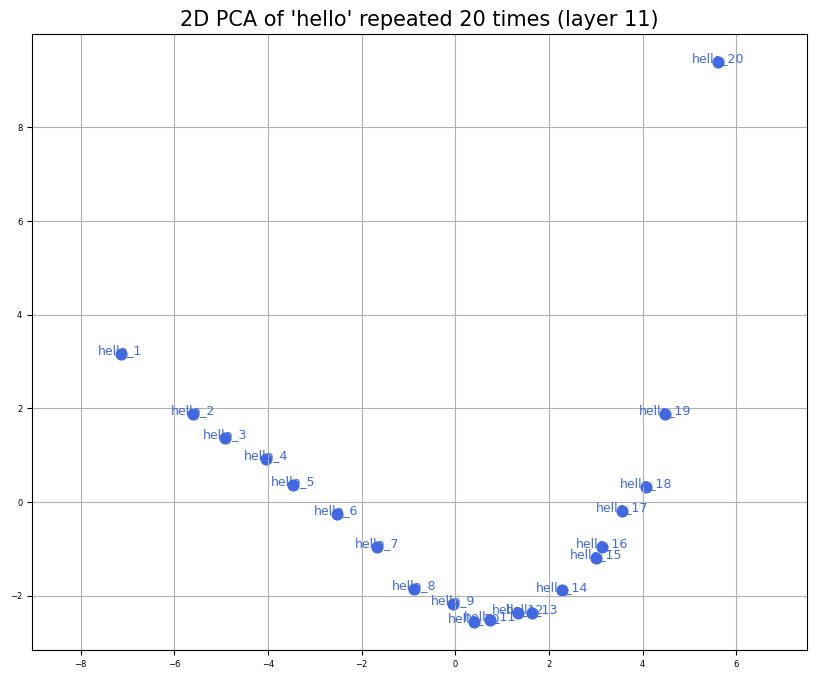

In [44]:
visualize_positional_embeddings_scatter(
    model_name="bert-base-uncased",
    num_tokens=20,
    layer_id=11
)

### Cross-encoder vs dual-encoder self-attention

In [45]:
text_a = "How many people live in Berlin?"
text_b = "Berlin has around three and a half million inhabitants."
compare_self_attention(
    model_name_cross="bert-base-uncased",
    model_name_dual="sentence-transformers/all-MiniLM-L6-v2",
    text_a=text_a,
    text_b=text_b
)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



=== CROSS-ENCODER ATTENTION (head_view) ===


<IPython.core.display.Javascript object>


=== DUAL-ENCODER ATTENTION (text_a) ===


<IPython.core.display.Javascript object>


=== DUAL-ENCODER ATTENTION (text_b) ===


<IPython.core.display.Javascript object>

### Interpretability

In [46]:
interpretability_attention(
    model_name="bert-base-uncased",
    text_a="What is the capital of Germany?",
    text_b="Berlin is the capital of Germany."
)


=== MODEL VIEW ATTENTION ===


<IPython.core.display.Javascript object>

Full self-attention visualization

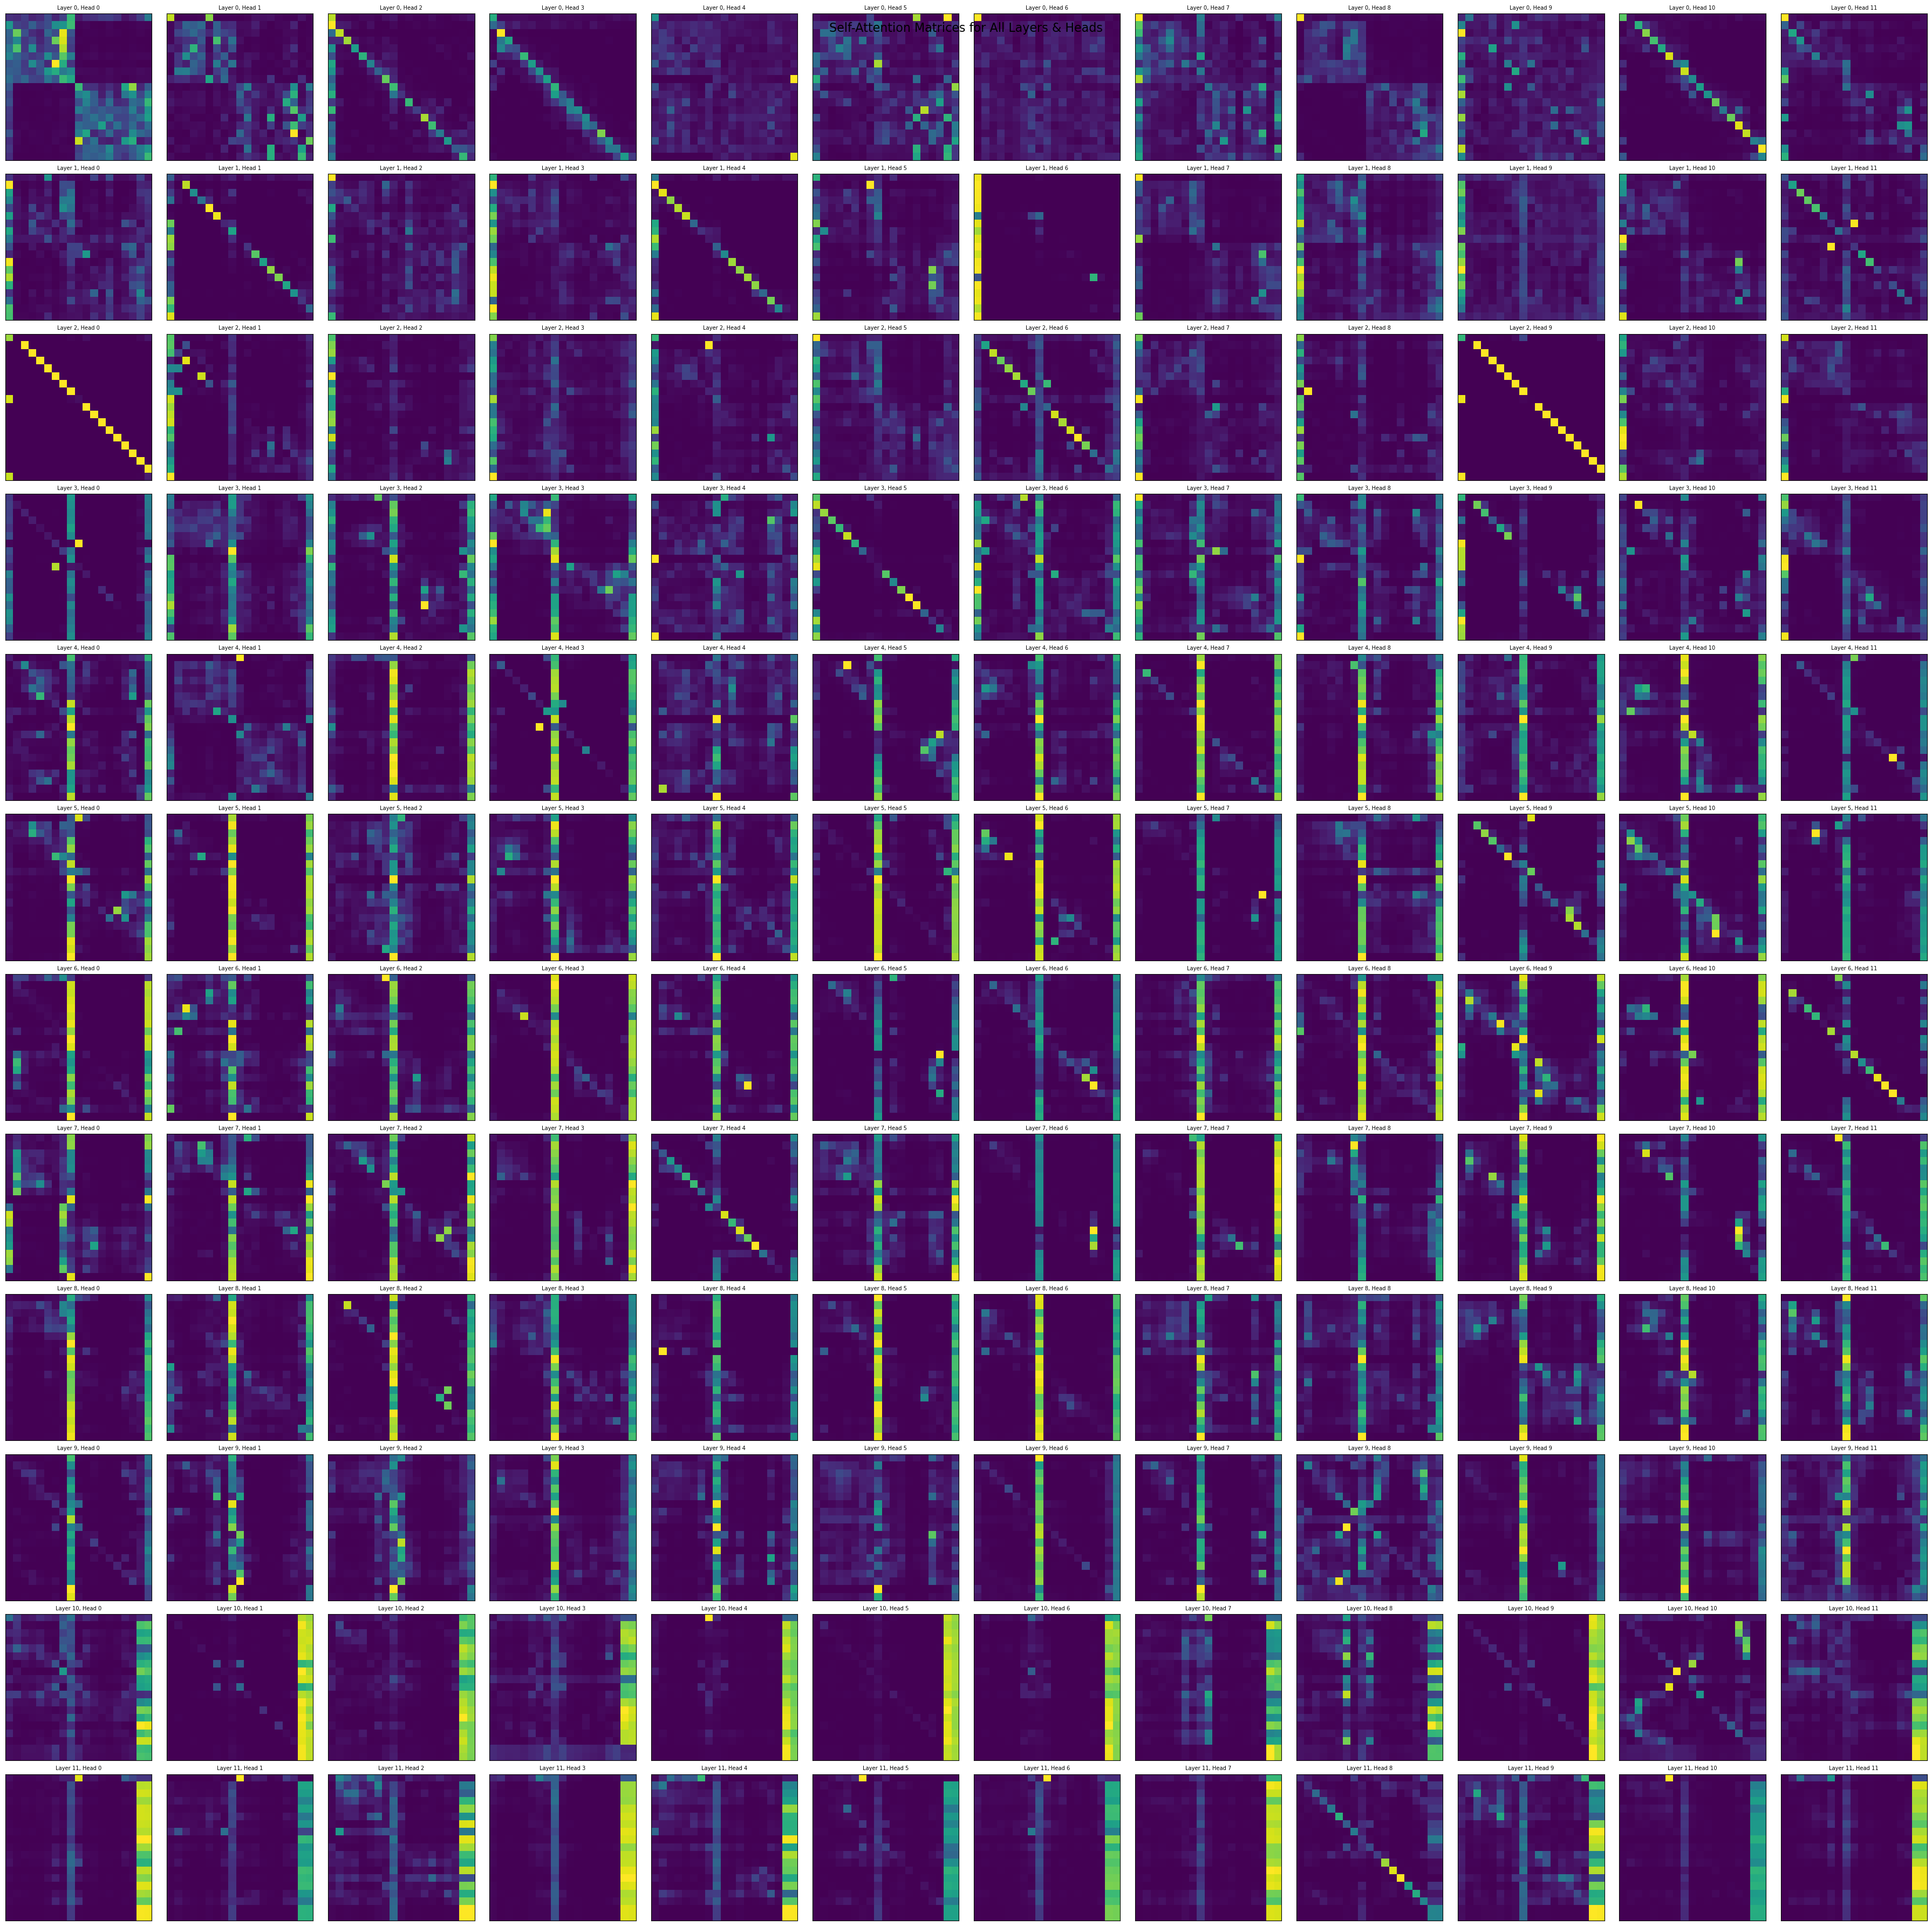

In [47]:
visualize_full_self_attention(
    model_name="bert-base-uncased",
    text_a="How many people live in Berlin?",
    text_b="Berlin has around 3.7 million inhabitants."
)